## Stochastic Discrete Model

#### imports and utils

In [1]:
import copy
import numpy as np
import sys
import seaborn as sb
import random as random
import matplotlib.pyplot as plt

In [2]:
def show_grid(M):
    min_val = np.min(M)
    max_val = np.max(M)
    sum_val = np.sum(M)

    fig, ax = plt.subplots(figsize=(20,6))
    sb.heatmap(M, annot=True, fmt=".4f", cmap='Blues',
           vmin=np.min(M), vmax=np.max(M), cbar_kws={"shrink": .8})
    plt.show()

    print(f'sum of mat cells: {sum_val}')
    print(f'max value is: {max_val}')
    print(f'min value is: {min_val}')

In [3]:
def sum_mats(mats):
    total = np.zeros((size,size))
    for mat in mats:
        total += mat
    return total

### Step 0

In [4]:
random.seed(6)
size = 16
probs = [0.2, 0.6, 0.2]
agents = [[13,6],[14,8],[13,9],[12,11]]
# max_damage = [agent[0] for agent in agents]
max_damage = [size for agent in agents]

initial_agents_probs = [np.zeros((size,size)) for _ in agents]
for i in range(len(agents)):
    agent = agents[i]
    r,c = agent
    initial_agents_probs[i][r][c] = 1

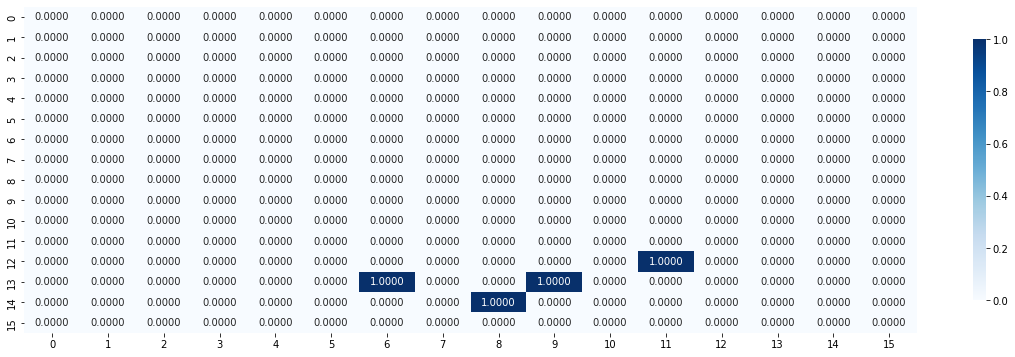

sum of mat cells: 4.0
max value is: 1.0
min value is: 0.0


In [5]:
show_grid(sum_mats(initial_agents_probs))

### Step t

In [6]:
def advance(M):
    for i in range(len(M)-1):
        for j in range(1,len(M)-1):
            left = M[i+1][j-1]
            under = M[i+1][j]
            right = M[i+1][j+1]
            M[i][j] = probs[0] * left + probs[1] * under + probs[2] * right
    for i in range(1,len(M)-1):
        M[len(M)-1][i] = 0
    return M

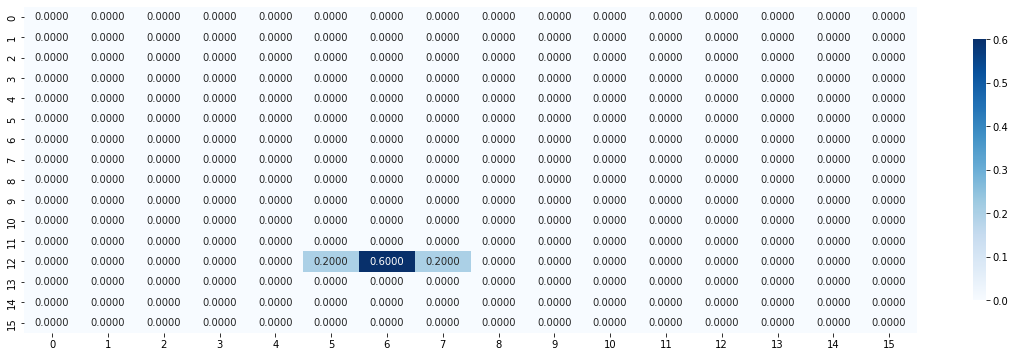

sum of mat cells: 1.0
max value is: 0.6
min value is: 0.0


In [7]:
t=1

advanced_agents_probs = copy.deepcopy(initial_agents_probs)
for _ in range(t):
    for i in range(len(agents)):
        advanced_agents_probs[i] = advance(advanced_agents_probs[i])

# grid of first agent
show_grid(advanced_agents_probs[0])

### Compute prob for each agent for each cell for each step (until T)

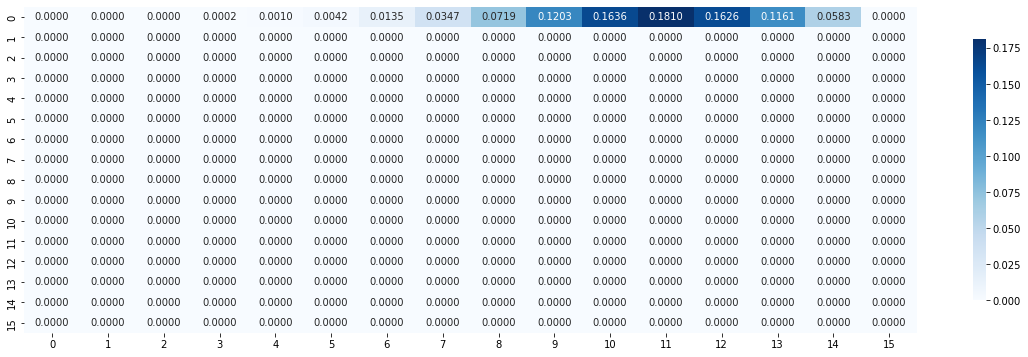

sum of mat cells: 0.9273924198399999
max value is: 0.18102337535999996
min value is: 0.0


In [8]:
T = size
advanced_per_t = [copy.deepcopy(initial_agents_probs)]

for t in range(T):
    # print(f'step {t}..')
    cur_advanced = []
    for M in copy.deepcopy(advanced_per_t[-1]):
        cur_advanced.append(advance(M))
    advanced_per_t.append(cur_advanced)

# show grid of an agent in some time
show_grid(advanced_per_t[12][3])

### Computing damage for each cell given arriving time using sum of damage for each agent

In [9]:
T=size

def per_cell_damage(i,j,time):
    damage = 0
    for a in range(len(agents)):
        # calc prob catch
        agent_reaching_time = agents[a][0] - i
        if time > agent_reaching_time:
            prob_catch = 0
        else:
            prob_catch = advanced_per_t[agent_reaching_time][a][i][j]

        damage += (1-prob_catch) * max_damage[a]
        damage += prob_catch * agent_reaching_time

    return damage

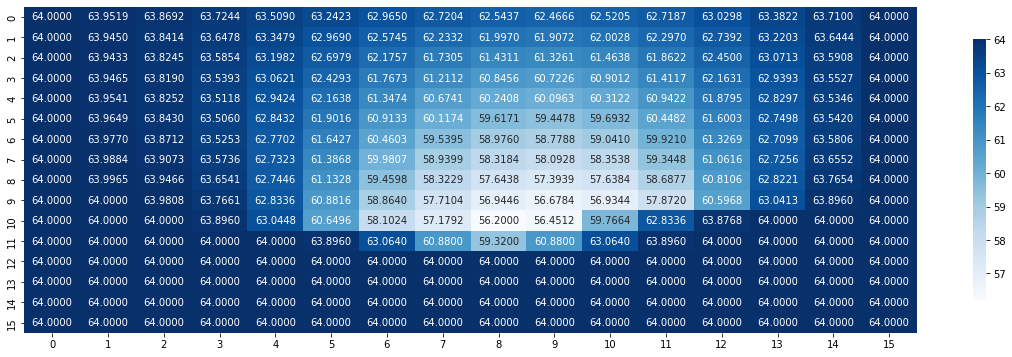

sum of mat cells: 16035.024543616204
max value is: 64.0
min value is: 56.199999999999996


In [10]:
damage_score = np.zeros((size,size))
for i in range(size):
    for j in range(size):
        damage_score[i][j] = per_cell_damage(i,j,time=3)

show_grid(damage_score)

### Arriving times of the robot for each cell

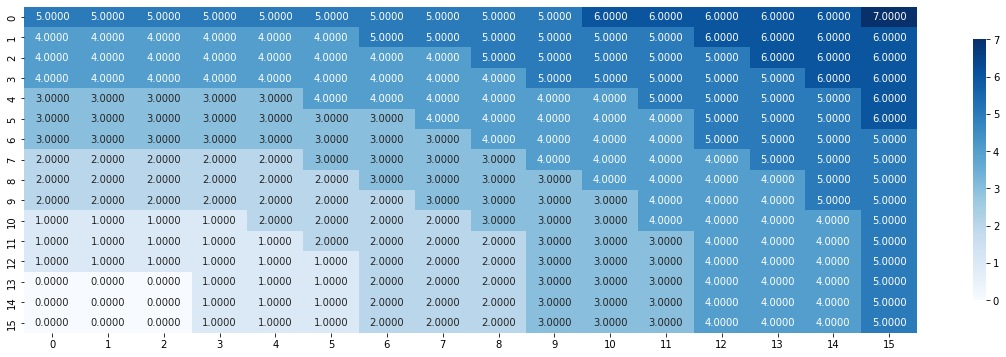

sum of mat cells: 875.0
max value is: 7.0
min value is: 0.0


In [11]:
robot = [size-1,0]
v = 3

arriving_times = np.zeros((size,size))
robot_loc = np.array((robot[0], robot[1]))
for i in range(size):
    for j in range(size):
        other = np.array((i,j))
        arriving_times[i][j] = int(np.linalg.norm(robot_loc-other) / v)

show_grid(arriving_times)

## Total damage

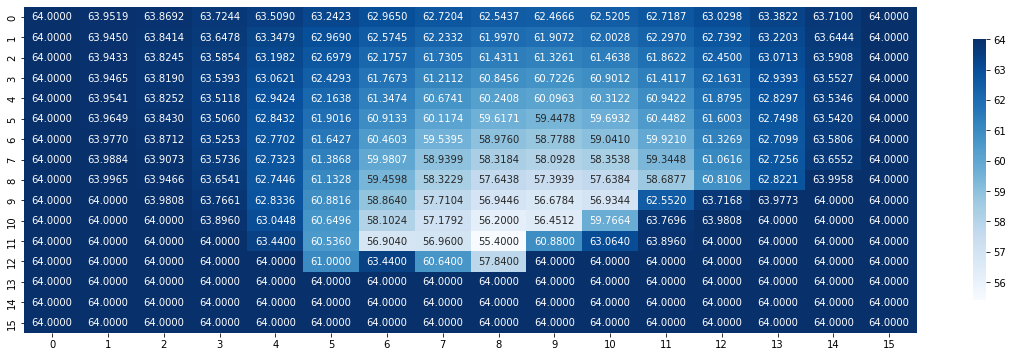

sum of mat cells: 16014.134943616205
max value is: 64.0
min value is: 55.4


In [12]:
damage_score = np.zeros((size,size))
for i in range(size):
    for j in range(size):
        damage_score[i][j] = per_cell_damage(i,j,int(arriving_times[i][j]))

show_grid(damage_score)

## Method 2: Find expected num of agents caught in each cell

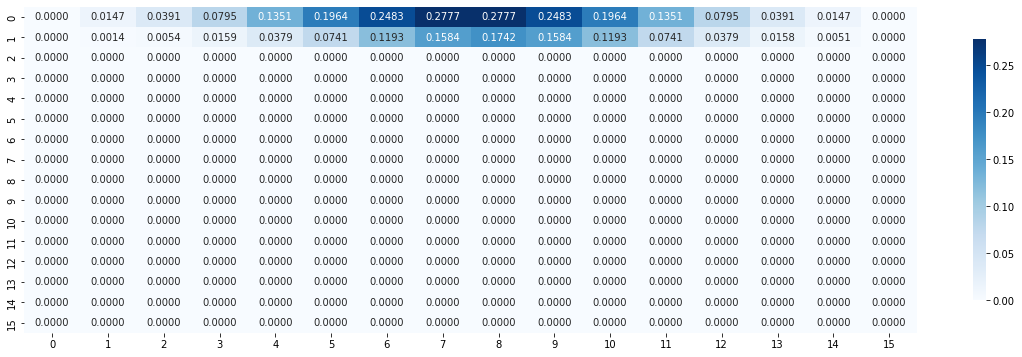

sum of mat cells: 2.9788732497919996
max value is: 0.2777007259648
min value is: 0.0


In [13]:
caught_per_t = [np.zeros((size,size)) for _ in range(T)]
for t in range(T):
    for M in advanced_per_t[t]:
        caught_per_t[t] += M

show_grid(caught_per_t[13])

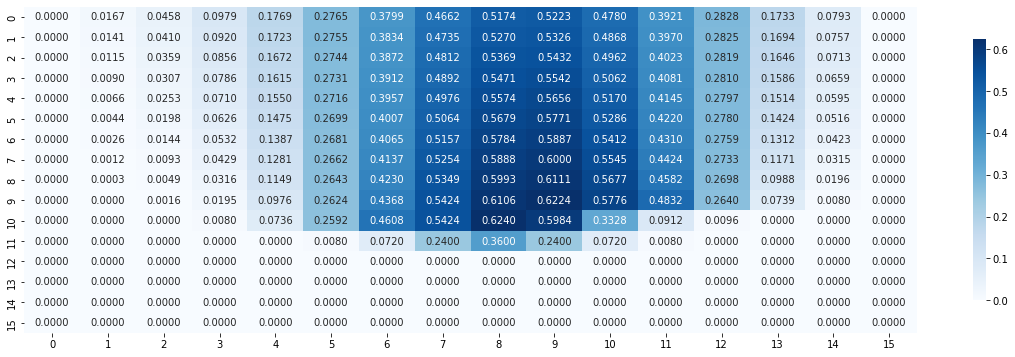

sum of mat cells: 43.6491713519616
max value is: 0.6240000000000001
min value is: 0.0


In [14]:
caught_from_t = [np.zeros((size,size)) for _ in range(T)]
caught_from_t[-1] = caught_per_t[-1]
for t in range(T-2,-1,-1):
    caught_from_t[t] = caught_from_t[t+1] + caught_per_t[t]

show_grid(caught_from_t[3])

In [15]:
def per_cell_damage2(i,j,time):
    damage = 0
    for t in range(time,T):
        damage += caught_per_t[t][i][j] * t

    damage += (len(agents) - caught_from_t[time][i][j]) * size
    return damage

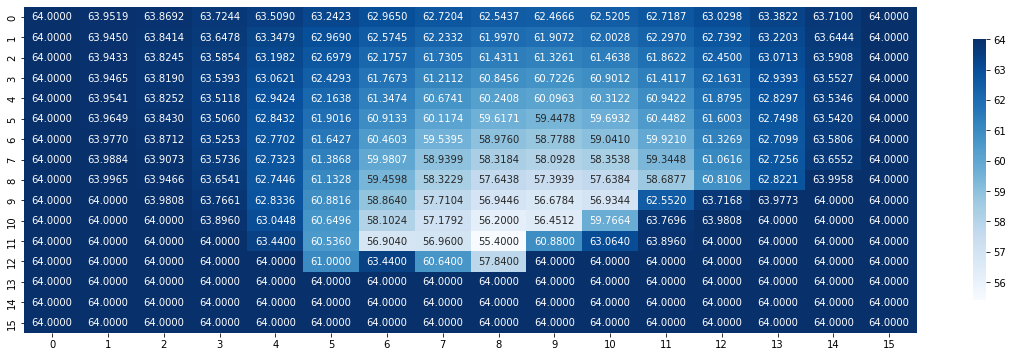

sum of mat cells: 16014.134943616205
max value is: 64.0
min value is: 55.4
sum of mat cells: 16014.134943616205
max value is: 64.0
min value is: 55.4


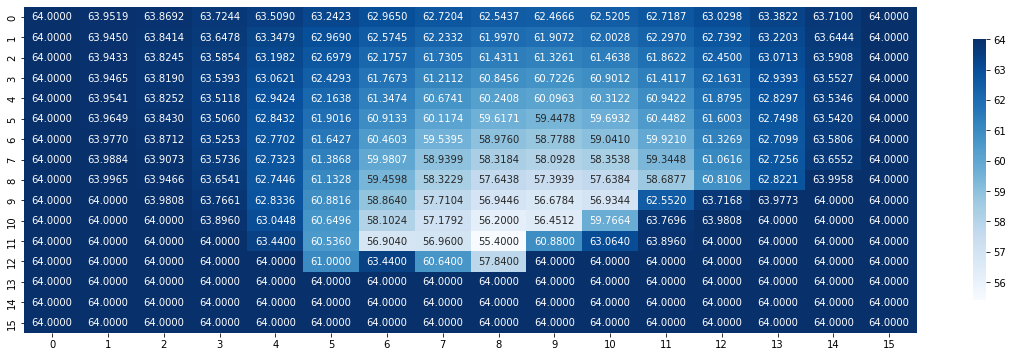

In [16]:
damage_score2 = np.zeros((size,size))
for i in range(size):
    for j in range(size):
        damage_score2[i][j] = per_cell_damage2(i,j,int(arriving_times[i][j]))

show_grid(damage_score)
show_grid(damage_score2)

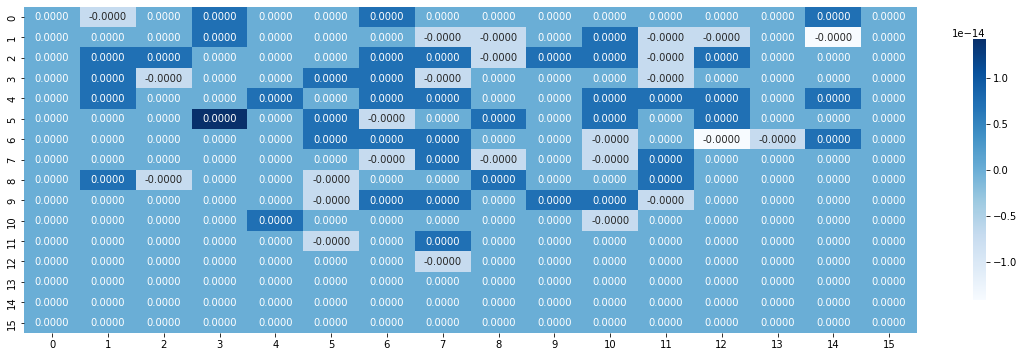

sum of mat cells: 1.2079226507921703e-13
max value is: 1.4210854715202004e-14
min value is: -1.4210854715202004e-14


In [17]:
diff = damage_score2 - damage_score
show_grid(diff)